# 0. Preparation
First, import related packages and load the data.

In [1]:
from IPython.display import clear_output
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import text as ktxt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
nltk.download('wordnet')


def hint(message):
    """
    erase previous ipynb output and show new message
    """
    clear_output()
    print(message)
    

np.random.seed()

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['comment_text'].fillna("unknown", inplace=True)
test['comment_text'].fillna("unknown", inplace=True)

labels = [
    'toxic', 
    'severe_toxic', 
    'obscene', 
    'threat', 
    'insult', 
    'identity_hate'
]

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ChuanLi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Overview
A quick glance at the training data:

In [2]:
print('Train set size:\t%d\nTest set size:\t%d' % (len(train), len(test)))
train.head()

Train set size:	159571
Test set size:	153164


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here are a few random samples of the comments.

In [3]:
    show_count = 3
    for i in range(1, show_count+1):
        print('\n----- Sample %d start -----\n' % i)
        print(train['comment_text'][np.random.randint(len(train))])
        print('\n------ Sample %d end ------\n' % i)


----- Sample 1 start -----

License to Wed

John was actually the main star of License to Wed.  He was not a supporting character.

------ Sample 1 end ------


----- Sample 2 start -----

Oh wait.. But what about an aircraft and fire? Empire state building had that happen.. oh look it still stands today!

------ Sample 2 end ------


----- Sample 3 start -----

Whenever you have a chance, could you please take a look at this. I've made a number of changes per peer review but would still appreciate a second set of eyes on it. Thanks.

------ Sample 3 end ------



# 2. Original Data Statistics

## 2.1 Distribution of the Labels.

In [4]:
train['none'] = 1 - train[labels].max(axis=1)
print('label distribution: ')
print(train.describe().loc['mean'].round(4))

label distribution: 
toxic            0.0958
severe_toxic     0.0100
obscene          0.0529
threat           0.0030
insult           0.0494
identity_hate    0.0088
none             0.8983
Name: mean, dtype: float64


## 2.2 Vocabulary Size

In [5]:
tr_tkzr = ktxt.Tokenizer()
tr_tkzr.fit_on_texts(train['comment_text'])
print("Train set vocabulary size: %d" % (len(tr_tkzr.word_index)))

Train set vocabulary size: 210337


In [6]:
te_tkzr = ktxt.Tokenizer()
te_tkzr.fit_on_texts(test['comment_text'])
print("Test set vocabulary size: %d" % (len(te_tkzr.word_index)))

Test set vocabulary size: 273192


## 2.3 Token-Count Distribution
One way to preprocess the data is to build a dictionary and map the words to their indices. The amount of tokens these comments would yield could be important when designing the model.

In [7]:
train_dirty_seq = tr_tkzr.texts_to_sequences(train['comment_text'])
test_dirty_seq = tr_tkzr.texts_to_sequences(test['comment_text'])
train_dirty_word_counts = [ len(seq) for seq in train_dirty_seq ]
test_dirty_word_counts = [ len(seq) for seq in test_dirty_seq ]
print("\tMin\tMean\tMax")
print("Train\t%d\t%d\t%d" % (
    np.min(train_dirty_word_counts), 
    np.mean(train_dirty_word_counts), 
    np.max(train_dirty_word_counts)
))
print("Test\t%d\t%d\t%d" % (
    np.min(test_dirty_word_counts), 
    np.mean(test_dirty_word_counts), 
    np.max(test_dirty_word_counts)
))

	Min	Mean	Max
Train	1	68	1403
Test	0	59	2142


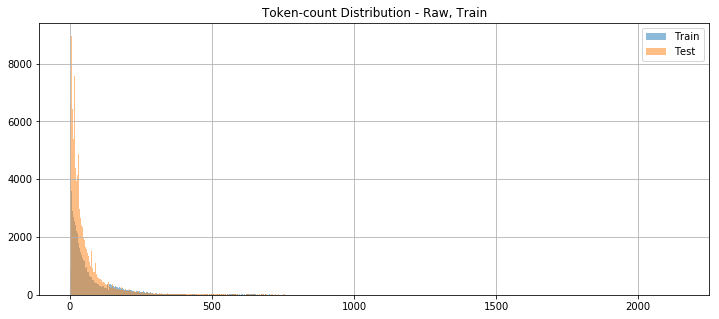

In [8]:
plt.figure(2, figsize=(12, 5))
plt.hist(train_dirty_word_counts, bins=1000, alpha=0.5, label='Train')
plt.hist(test_dirty_word_counts, bins=1000, alpha=0.5, label='Test')
plt.title("Token-count Distribution - Raw, Train")
plt.grid(True); plt.legend(); plt.show()

# 3. Cleaned Data Statistics
The original data came with a lot of noise such as usernames and IP addresses. They should be factored during the learning process for many reasons. Now we will attempt to clean up the origianl data and see how the numbers change. Note that this is just a basic demo. There are most likely more and better ways to clean the data.

## 3.1 Cleaning

In [9]:
tkzr = TweetTokenizer(preserve_case=False)
eng_stopwords = (
    'what', 'which', 'who', 'whom', 
    'this', 'that', 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 
    'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 
    'do', 'does', 'did', 'doing', 
    'a', 'an', 'the', 
    'and', 'but', 'if', 'or', 
    'because', 'as', 'until', 'while', 
    'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 
    'into', 'through', 'during', 'before', 'after', 
    'above', 'below', 'to', 'from', 
    'up', 'down', 'in', 'out', 'on', 'off', 
    'over', 'under', 'again', 'further', 
    'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 
    'how', 'all', 'any', 'both', 'each', 
    'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 
    'own', 'same', 'so', 'than', 'too', 'very', 
    'can', 'will', 'just', 'don', 'should', 'now'
)
lmtzr = WordNetLemmatizer()
appos = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not"
}

def preprocess(comment):
  
    # credit to the author of this post:
    # https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

    # remove special format
    comment = re.sub('\n\t', '', comment)

    # remove IP addresses
    comment = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' specipaddress ', comment)

    # remove username
    comment = re.sub("\[\[User.*\]", ' specusername ', comment)
    comment = re.sub("\[\[User.*\|", ' specusername ', comment)

    # tokenization 
    tokens = tkzr.tokenize(comment)

    # aphostophe replacement
    tokens = [ appos[token] if token in appos else token for token in tokens]

    # remove stopwords
    tokens = [ token for token in tokens if not token in eng_stopwords ]
    
    # stemming
    tokens = [ lmtzr.lemmatize(token, 'v') for token in tokens]

    return " ".join(tokens)
  

hint('Cleaning train set...')
train_clean = train['comment_text'].apply(lambda c: preprocess(c))
hint('Cleaning test set...')
test_clean = test['comment_text'].apply(lambda c: preprocess(c))
hint('Done')

Done


## 3.2 Token-Count Distribution:

In [10]:
train_clean_seq = tr_tkzr.texts_to_sequences(train_clean)
test_clean_seq = tr_tkzr.texts_to_sequences(test_clean)
train_clean_word_counts = [ len(seq) for seq in train_clean_seq ]
test_clean_word_counts = [ len(seq) for seq in test_clean_seq ]
print("\tMin\tMean\tMax")
print("Train\t%d\t%d\t%d" % (
    np.min(train_clean_word_counts), 
    np.mean(train_clean_word_counts), 
    np.max(train_clean_word_counts)
))
print("Test\t%d\t%d\t%d" % (
    np.min(test_clean_word_counts), 
    np.mean(test_clean_word_counts), 
    np.max(test_clean_word_counts)
))

	Min	Mean	Max
Train	0	43	1387
Test	0	38	2142


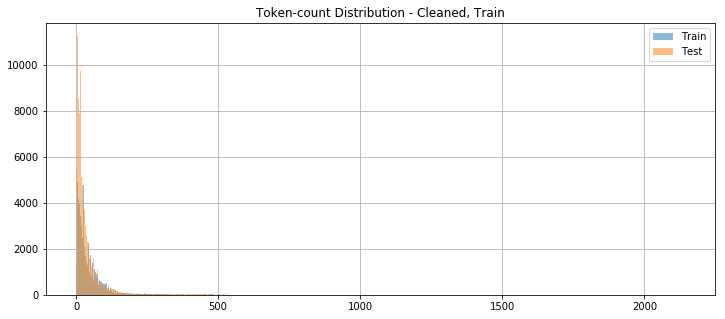

In [11]:
plt.figure(3, figsize=(12, 5))
plt.hist(train_clean_word_counts, bins=1000, alpha=0.5, label='Train')
plt.hist(test_clean_word_counts, bins=1000, alpha=0.5, label='Test')
plt.title("Token-count Distribution - Cleaned, Train")
plt.grid(True); plt.legend(); plt.show()

## 3.3 Vocabulary size:

In [12]:
tr_tkzr = ktxt.Tokenizer()
tr_tkzr.fit_on_texts(train_clean)
print("Cleaned train set vocabulary size: %d" % (len(tr_tkzr.word_index)))

Cleaned train set vocabulary size: 184644


In [13]:
te_tkzr = ktxt.Tokenizer()
te_tkzr.fit_on_texts(test_clean)
print("Cleaned test set vocabulary size: %d" % (len(te_tkzr.word_index)))

Cleaned test set vocabulary size: 244197
